In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import plotly.express as px
from sklearn.decomposition import PCA
from collections import Counter

# For working with google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
!pip3 install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
cd gdrive/MyDrive/Colab\ Notebooks/'Deep learning'/Spotify_Popularity_Predictor

/content/gdrive/MyDrive/Colab Notebooks/Deep learning/Spotify_Popularity_Predictor


## Auxiliary functions

In [12]:
def reduce_dimensionality(dataset, n_dimensions):
  """Reduces the size of the dataset to a given parameter"""
  pca = PCA(n_components=n_dimensions)
  return pca.fit_transform(dataset)

def preprocess_general_dataset(df):
  df = df.fillna(0)
  df['artist_hotttness'] = df['artist_hotttness'] * 10
  df['year'] = df['year']/df['year'].max()
  df['duration'] = df['duration']/df['duration'].max()
  df['loudness'] = (df.loudness - df.loudness.mean())/df.loudness.std()
  #coors = reduce_dimensionality(df[df.columns[8:]], 2500)
  #df = df[df.columns[0:8]]
  #for i in range(coors.shape[1]):
  #  df[i] = coors[:, i]
  return df

def preprocess_general_dataset_without_zeros(df):
  df = df.fillna(0)
  df['artist_hotttness'] = df['artist_hotttness'] * 10
  df['year'] = df['year']/df['year'].max()
  df['duration'] = df['duration']/df['duration'].max()
  df['loudness'] = (df.loudness - df.loudness.mean())/df.loudness.std()
  ####
  dropped=[]
  df = df.fillna(0)
  for col in df.columns:
    if len(Counter(df[col])) == 1:
      dropped.append(col)
  df.drop(dropped, axis=1, inplace=True)
  ####
  coors = reduce_dimensionality(df[df.columns[6:]], 500)
  df = df[df.columns[0:6]]
  for i in range(coors.shape[1]):
    df[i] = coors[:, i]
  return df

def generate_dataset(train_size, val_size):
  df = pd.read_csv('data/general_data.csv')
  df = df.dropna(subset=['hotttness'])
  y = df['hotttness'].to_numpy()
  df.drop('hotttness', axis = 1, inplace=True)
  x = preprocess_general_dataset(df)
  #x = preprocess_general_dataset_without_zeros(df)
  x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_size, shuffle = True)
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 1 - val_size, shuffle = True)
  return x_train, y_train, x_test, y_test, x_val, y_val

In [22]:
dropped=[]
df = df.fillna(0)
for col in df.columns:
  if len(Counter(df[col])) == 1:
    dropped.append(col)
df.drop(dropped, axis=1, inplace=True)

(5648, 3721)

In [26]:
df[df.columns[5]]

1       0.677088
2       0.590449
3       0.445217
4       0.226516
5       0.386238
          ...   
9992    0.373611
9993    0.393122
9994    0.430697
9995    0.434346
9997    0.472495
Name: artist_hotttness, Length: 5648, dtype: float64

# General Data

List of features:

- fade_out
- fade_in
- danceability (all zeros...)
- duration
- energy (all zeros...)
- loudness
- year
- artist_hotttness
- labels [8:]

In [12]:
df = pd.read_csv('data/general_data.csv')
df = df.dropna(subset=['hotttness'])
y = df['hotttness']
df.drop('hotttness', axis = 1, inplace= True)
df.head()

,fade_out,fade_in,danceability,duration,energy,loudness,year,artist_hotttness,post-hardcore,screamo,...,artist_term: baltic metal,artist_mbtags: estonian,artist_term: epitaph,artist_term: gothic electro,artist_term: jazz and funk,artist_term: progressive alternative metal,artist_term: intelligent drum and bass,artist_mbtags: northampton,artist_term: 90s turkish pop,artist_term: baile funk
1,0.999999,0.000743,0.0,277.28934,0,-5.640,2002,0.677088,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.974424,0.000526,0.0,205.16526,0,-3.862,2008,0.590449,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.964369,0.000000,0.0,267.17995,0,-10.481,2009,0.445217,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.963616,0.001365,0.0,208.11710,0,-11.703,0,0.226516,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.986727,0.002235,0.0,201.32526,0,-6.645,0,0.386238,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### A bit of data analysis

We can see that there is a problem with the amount of zeros in the dataset

0
1000
2000
3000
4000
5000


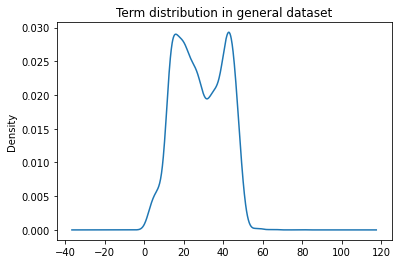

In [ ]:
terms = df[df.columns[8:]].fillna(0)
term_distribution = []
for i in range(len(terms)):
  term_distribution.append(len(Counter(terms.iloc[i])))
  if i%1000 == 0:
    print(i)
df['term_distribution'] = term_distribution
df['term_distribution'].plot.kde(title='Term distribution in general dataset').figure.savefig('images/general_dataset_term_distribution.png')

In [ ]:
df.term_distribution.describe()

count    5648.000000
mean       27.548690
std        12.184191
min         1.000000
25%        17.000000
50%        27.000000
75%        39.000000
max        78.000000
Name: term_distribution, dtype: float64

In [ ]:
len(dropped)

4350

We can approach it from the column  level and see how many columns have zero values

(0.0, 1750.0)

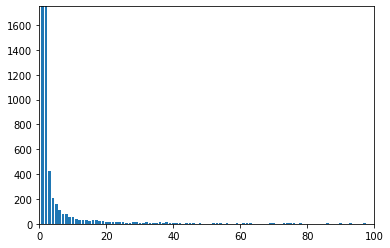

In [ ]:
import matplotlib.pyplot as plt

terms = df[df.columns[8:]].fillna(0)
term_distribution = []
for col in terms.columns:
  term_distribution.append(len(Counter(terms[col])))

w = Counter(term_distribution)
fig = plt.bar(w.keys(), w.values())
plt.xlim([0, 100])
plt.ylim([0, 1750])

Dimensionality reduction

In [ ]:
coors = reduce_dimensionality(terms, 2)

aux = pd.DataFrame({
    'hotttness': y,
    'x': coors[:, 0],
    'y': coors[:, 1] 
})

fig = px.scatter(aux, x='x', y='y', color = 'hotttness')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = '2D representation of the terms in the general dataset'
#fig.write_image('images/general_dataset2D.png', scale=3, width = 1000, height = 480)
fig.show()

In [ ]:
coors = reduce_dimensionality(terms, 3)

aux = pd.DataFrame({
    'hotttness': y,
    'x': coors[:, 0],
    'y': coors[:, 1],
    'z': coors[:, 2]
})

fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'hotttness')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = '3D representation of the terms in the general dataset'
#fig.write_image('images/general_dataset3D.png', scale=3, width = 1000, height = 480)
fig.show()

Dimensionality reduction deleting terms that are completely zero

In [ ]:
dropped = []
for col in terms.columns:
  if len(Counter(terms[col])) == 1:
    dropped.append(col)
terms.drop(dropped, axis=1, inplace=True)

coors = reduce_dimensionality(terms, 2)

aux = pd.DataFrame({
    'hotttness': y,
    'x': coors[:, 0],
    'y': coors[:, 1] 
})

fig = px.scatter(aux, x='x', y='y', color = 'hotttness')
fig.update_traces(marker=dict(size=5,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = '2D representation of the terms in the general dataset with no zeros'
#fig.write_image('images/general_dataset2D.png', scale=3, width = 1000, height = 480)
fig.show()

In [ ]:
coors = reduce_dimensionality(terms, 3)

aux = pd.DataFrame({
    'hotttness': y,
    'x': coors[:, 0],
    'y': coors[:, 1],
    'z': coors[:, 2]
})

fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'hotttness')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = '3D representation of the terms in the general dataset'
#fig.write_image('images/general_dataset3D.png', scale=3, width = 1000, height = 480)
fig.show()

### Data Loading

In [14]:
x_train, y_train, x_test, y_test, x_val, y_val = generate_dataset(0.8, 0.1)
x_train.shape

(4066, 8073)

### Model design and training

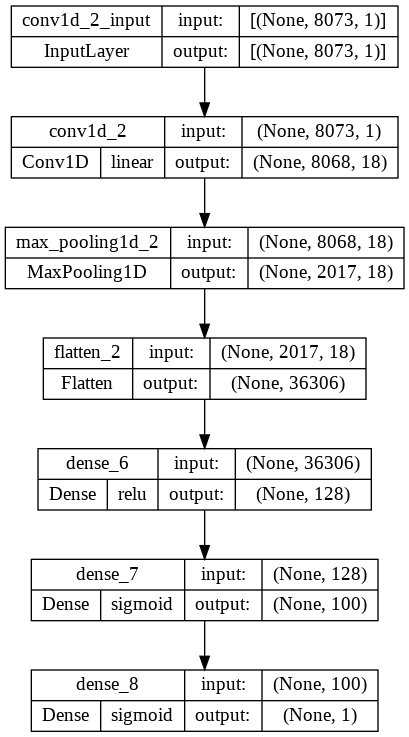

In [31]:
def generate_model():
  model = Sequential()
  model.add(layers.Conv1D(18, 6, padding='valid', kernel_regularizer='l2', input_shape=(8073, 1)))
  model.add(layers.MaxPooling1D(2, strides=4))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(100, activation ='sigmoid'))
  model.add(layers.Dense(1, activation ='sigmoid'))
  model.compile(optimizer=Adam(),
                loss= 'mse',
                metrics=['mae'])
  return model

model = generate_model()
plot_model(model, show_shapes=True, show_layer_activations=True, to_file='images/general_model.png')

In [32]:
history = model.fit(
    x_train, y_train,
    epochs = 50, batch_size = 128,
    validation_data=(x_val, y_val)
)

Epoch 1/50
32/32 [==============================] - 24s 708ms/step - loss: 0.0851 - mae: 0.2149 - val_loss: 0.0666 - val_mae: 0.1945
Epoch 2/50
32/32 [==============================] - 20s 630ms/step - loss: 0.0576 - mae: 0.1777 - val_loss: 0.0505 - val_mae: 0.1706
Epoch 3/50
32/32 [==============================] - 20s 642ms/step - loss: 0.0470 - mae: 0.1625 - val_loss: 0.0438 - val_mae: 0.1566
Epoch 4/50
32/32 [==============================] - 22s 679ms/step - loss: 0.0405 - mae: 0.1526 - val_loss: 0.0393 - val_mae: 0.1499
Epoch 5/50
32/32 [==============================] - 21s 643ms/step - loss: 0.0367 - mae: 0.1466 - val_loss: 0.0369 - val_mae: 0.1465
Epoch 6/50
32/32 [==============================] - 22s 701ms/step - loss: 0.0350 - mae: 0.1446 - val_loss: 0.0363 - val_mae: 0.1517
Epoch 7/50
32/32 [==============================] - 21s 671ms/step - loss: 0.0337 - mae: 0.1428 - val_loss: 0.0344 - val_mae: 0.1461
Epoch 8/50
32/32 [==============================] - 23s 726ms/step - 

In [33]:
# Convert the history into a df to plot it
name = 'general_model'

history = history.history
df = pd.DataFrame({'mse': history['loss'],  'mae': history['mae'], 'val_mse': history['val_loss'], 'val_mae': history['val_mae']})
df.index += 1
df.index.name = 'Epochs'

# Plot the accuracy of Training and Validation
fig = px.line(df, x=df.index, y=df['mae'])
fig.add_scatter(x=df.index, y=df['val_mae'], mode='lines')
fig['data'][0].showlegend = True  
fig['data'][0]['name'] = 'Training MAE'
fig['data'][1].showlegend = True
fig['data'][1]['name'] = 'Validation MAE'
fig['layout']['title'] = 'MAE evolution'
fig.write_image('images/%s_MAE.png'%name, scale = 10, width = 1400, height = 480)
fig.show()

# Plot the loss of Training and Validation
fig = px.line(df, x=df.index, y=df['mse'])
fig.add_scatter(x=df.index, y=df['val_mse'], mode='lines')
fig['data'][0].showlegend = True
fig['data'][0]['name'] = 'Training mse'
fig['data'][1].showlegend = True#
fig['data'][1]['name'] = 'Validation mse'
fig['layout']['title'] = 'MSE evolution'
fig.write_image('images/%s_MSE.png'%name, scale = 10, width = 1400, height = 480)
fig.show()

In [34]:
model.save('models/general_model.h5')

### Test and results analysis

In [35]:
model.evaluate(x_test, y_test)

36/36 [==============================] - 2s 49ms/step - loss: 0.0405 - mae: 0.1557


[0.040479619055986404, 0.15566164255142212]

In [36]:
# Predictions
y_pred = model.predict(x_test)

# test dataset plot preparation
coors = reduce_dimensionality(x_test, 3)

# Error difference calculation
abs_difference = []
diff = []
for i in range(len(y_test)):
  abs_difference.append(abs(y_pred[i][0] - y_test[i]))
  diff.append(y_pred[i][0] - y_test[i])

aux = pd.DataFrame({
      'x': coors[:, 0],
      'y': coors[:, 1], 
      'z': coors[:, 2],
      'y_pred': y_pred.reshape(1, -1)[0],
      'y_test': y_test,
      'diff': diff,
      'abs_diff': abs_difference
  })

36/36 [==============================] - 2s 48ms/step


In [37]:
aux.head()

,x,y,z,y_pred,y_test,diff,abs_diff
0,-2.109210,-0.814719,0.744285,0.722180,0.906078,-0.183898,0.183898
1,0.441348,1.720166,0.378486,0.183903,0.377532,-0.193628,0.193628
2,1.104242,-0.359651,0.092137,0.215828,0.228580,-0.012752,0.012752
3,1.557570,1.546202,-0.611705,0.141389,0.000000,0.141389,0.141389
4,0.469658,0.581896,-0.328897,0.178969,0.000000,0.178969,0.178969


In [38]:
# Plot
fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'abs_diff')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = 'Absolute error plot of the test phase'
fig.show()

In [39]:
# Plot
fig = px.scatter_3d(aux, x='x', y='y', z='z', color = 'diff')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig['layout']['title'] = 'Error plot of the test phase'
fig.show()

In [40]:
aux['diff'].describe()

count    1130.000000
mean        0.008653
std         0.197522
min        -0.647414
25%        -0.124619
50%         0.018194
75%         0.121973
max         0.598251
Name: diff, dtype: float64

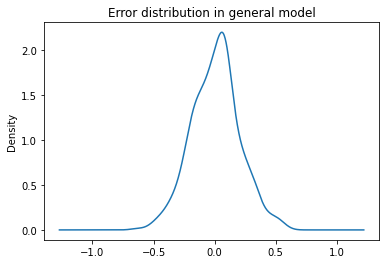

In [43]:
aux['diff'].plot.kde(title='Error distribution in general model').figure.savefig('images/general_dataset_error_distribution.png')

In [42]:
print(aux[aux['diff'] > 0.15])
print(aux[aux['diff'] < -0.15])

             x         y         z    y_pred    y_test      diff  abs_diff
4     0.469658  0.581896 -0.328897  0.178969  0.000000  0.178969  0.178969
9     1.001545  0.074103 -0.530732  0.322232  0.000000  0.322232  0.322232
13   -4.090218  0.816235 -0.827152  0.728637  0.565667  0.162970  0.162970
17    0.925574  0.315593 -0.276180  0.295434  0.000000  0.295434  0.295434
21   -0.400500 -0.567039 -0.808450  0.252925  0.000000  0.252925  0.252925
...        ...       ...       ...       ...       ...       ...       ...
1096 -0.216030 -0.337234 -0.611058  0.423088  0.212045  0.211042  0.211042
1107  0.666677 -1.111544 -0.685883  0.204044  0.000000  0.204044  0.204044
1109 -0.541829  0.617641  0.334068  0.424267  0.215080  0.209186  0.209186
1120 -0.083634  1.176019  1.008747  0.508902  0.000000  0.508902  0.508902
1122  0.989225 -0.031581  0.028968  0.157338  0.000000  0.157338  0.157338

[238 rows x 7 columns]
             x         y         z    y_pred    y_test      diff  abs_diff
0